In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.svm import LinearSVC

from imblearn.over_sampling import SMOTE

In [2]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2242_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2242_inactives.csv')

In [3]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 715
inactives: 183379


In [4]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=300, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=300, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

In [5]:
df = pd.concat([actives_train, inactives_train[:600]], ignore_index=True)

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,2,0,0,2,2,0,0,0,0,0,...,0,1,0,0,0,5.28540,-0.798443,0.413793,3.18822,0
1,3,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,5.55459,-0.276209,0.529412,3.96809,0
2,1,0,0,1,3,0,0,0,0,0,...,0,0,0,0,0,5.35800,-0.672000,0.194000,2.46800,1
3,1,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,4.70044,-0.295978,0.285714,2.57062,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,4.52356,-0.001505,0.000000,-1.48188,0


In [7]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [8]:
y.value_counts()

0    600
1    415
Name: activity, dtype: int64

In [9]:
import matplotlib.pyplot as plt

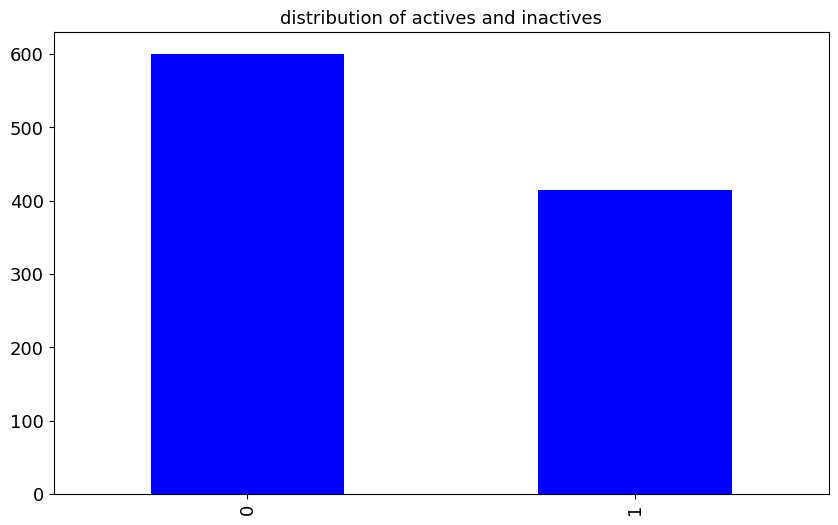

In [10]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.01, random_state=42)

In [12]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_validate = pd.DataFrame(X_validate, columns=X.columns)

### Removing low variance features to improve model performance

In [13]:
from sklearn.feature_selection import VarianceThreshold


thresh = VarianceThreshold(threshold=0.03)
thresh.fit(X_train)
mask = thresh.get_support()


X_train = X_train.loc[:, mask]
X_validatee = X_validate.loc[:, mask]

X_train.shape, X_validate.shape

((1004, 591), (11, 777))

In [14]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [15]:
y_train_resampled.value_counts()

0    596
1    596
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

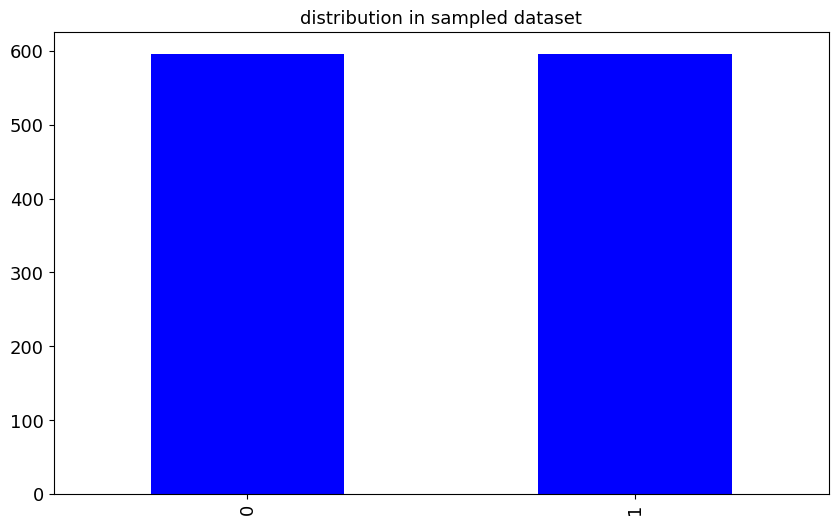

In [16]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [17]:
model = LinearSVC(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

### evaluating the model using the test data

In [18]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [19]:
len(testing_data)

600

In [20]:
testing_data['activity'].value_counts()

1    300
0    300
Name: activity, dtype: int64

In [21]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,1,3,0,0,0,0,0,...,0,0,0,0,0,4.954,-0.280,0.231,3.149,1
1,1,0,0,2,2,0,0,0,0,0,...,0,1,0,0,1,5.285,-0.234,0.214,0.636,1
2,2,0,0,2,2,0,0,0,0,0,...,0,2,0,0,0,5.170,-0.658,0.444,3.317,1
3,2,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.170,-0.823,0.444,3.307,1
4,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,4.858,-0.717,0.000,1.820,1


In [22]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

600


In [23]:
testing_data_x = pd.DataFrame(testing_data_x, columns=X.columns)

In [24]:
testing_data_x = testing_data_x.loc[:, mask]

In [25]:
testing_data_x.head()

,D001,D002,D004,D005,D006,D012,D013,D014,D015,D016,...,D763,D765,D768,D770,D771,D773,D774,D775,D776,D777
0,-0.357758,-0.070746,0.361055,0.695519,-0.063246,-0.931478,1.300301,-1.040472,-1.144659,-1.381951,...,-0.459381,-1.629534,-0.181444,-0.637798,-0.149677,-0.127257,-0.373859,0.488856,-0.331459,0.901090
1,-0.357758,-0.070746,1.777068,-0.418199,-0.063246,0.413817,1.300301,-0.727144,-0.912732,2.115894,...,-0.459381,0.566509,-0.181444,1.155897,-0.149677,7.858117,0.574374,0.612019,-0.438000,-1.140594
2,0.898149,-0.070746,1.777068,-0.418199,-0.063246,0.638032,0.824014,-0.413817,-0.513817,-0.798977,...,-0.459381,0.566509,-0.181444,2.949593,-0.149677,-0.127257,0.244927,-0.523218,1.003441,1.037582
3,0.898149,-0.070746,1.777068,-0.418199,-0.063246,0.638032,-0.128559,-0.727144,-0.857069,-0.798977,...,-0.459381,-0.531512,-0.181444,-0.637798,-0.149677,-0.127257,0.244927,-0.964997,1.003441,1.029457
4,-1.613665,-0.070746,0.361055,-1.531917,-0.063246,-1.379910,-1.081133,0.839493,1.462202,0.949946,...,-0.459381,-1.629534,-0.181444,1.155897,-0.149677,-0.127257,-0.648876,-0.681188,-1.779167,-0.178654


In [26]:
model.predict((testing_data_x.iloc[500]).to_numpy().reshape(1, -1))

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [27]:
# converting the test dataset into a numpy array
testing_data_x = testing_data_x.to_numpy()

#### Model's accuracy on test set

In [28]:
model.score(testing_data_x, testing_data_y)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


0.6983333333333334

### evaluating model's performance with F1 score, precision, recall, etc

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [30]:
y_pred = model.decision_function(testing_data_x)
y_pred_rounded = (y_pred > 0).astype(int)
y_pred_rounded.shape == y_pred.shape

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


True

In [31]:
testing_data_y.shape == y_pred.shape

True

In [32]:
accuracy = accuracy_score(testing_data_y, y_pred_rounded)
precision = precision_score(testing_data_y, y_pred_rounded)
recall = recall_score(testing_data_y, y_pred_rounded)
f1 = f1_score(testing_data_y, y_pred_rounded)

In [33]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.6983333333333334
precision is 0.6386946386946387
recall is 0.9133333333333333
f1 is 0.7517146776406035
